# Solving Convection - Diffusion Equation using Finite Element Methods and its stabilization techniques

##  Problem 1:

Consider the 1d convection-diffusion equation with dirichlet boundary condition : 

$$ -\epsilon u'' + bu' = 1,\;\;\textrm{in} \;\;\Omega = [0,1]$$

$$ u(0) = u(1) = 0 $$

where, $\epsilon$ and $ b $ are diffusion and convection coefficients respectively.
We seek to find the solution $u \in V$, where $V$ is some finite element space satisfying the boundary condition.
Note that the source term, i.e the rhs of the equation is constant (1 here).

The exact solution to the above problem is known as is given by
$$ u = \frac{1}{b}\left(x - \frac{1-e^{\frac{bx}{\epsilon}}}{1-e^{\frac{b}{\epsilon}}}\right) $$

### 1. Galerkin

We write the above problem in variational form by multiplying by test function $v \in V$ and integrating by parts over domain $\Omega$ 

$$ \int_\Omega (-\epsilon u'' + bu')v\,dx = \int_\Omega v\,dx $$

$$ \epsilon \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx = \int_\Omega v\,dx $$

Now let us write the problem in compact form as follows

$$ u \in V:\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := \epsilon \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx$$

$$ l(v) := \int_\Omega v\,dx $$

The above problem is solved below by using `firedrake`.

Import the required libraries i.e `firedrake`, `matplotlib` and `numpy` to solve the problem.

In [118]:
import firedrake as fe
import matplotlib.pyplot as plt
import numpy as np

The mesh fo the above 1d problem is defined using `firedrake.UnitIntervalMesh`. Here we take $N$, the number of elements in the mesh as 10.

In [119]:
N = 10
mesh = fe.UnitIntervalMesh(N)

Define the value of diffusion coefficient $\epsilon$ and convection coefficient $b$ for the problem.

In [120]:
epsilon = 1  # diffusion constant 
b = 1 # convection constant

Mesh Peclet number is defined as 
$$ Pe = \frac{bh}{2\epsilon}$$
where $h$ is the mesh size. Here, $h = \frac{1}{N}$.

In [121]:
def peclet_number(b, N, epsilon):
    """ returns Peclet number
    
    Keyword Arguments:
    
    b - convection coefficient
    
    N - mesh size
    
    epsilon - diffusion coefficient
    """
    h = 1./N
    
    return b*h/(2.*epsilon)

In [122]:
pe = peclet_number(b,N,epsilon)
print('Pe =',pe)

Pe = 0.05


Now, we shall define the finite dimensional function space $V$ in which the problem is to be solved. It is defined using `firedrake.FunctionSpace` which takes the mesh, the finite element family and degree of the finite element family as inputs. We shall choose the space of piecewise linear polynomials that are continuous between elements.

In [123]:
V = fe.FunctionSpace(mesh, 'CG', 1)

Now, we shall define the `TestFunction` and `Trial function` on the function space $V$

In [124]:
u = fe.TrialFunction(V)
v = fe.TestFunction(V)

Let us get the `SpatialCoordinates` $x$ for the mesh.

In [125]:
x = fe.SpatialCoordinate(mesh)[0]

Let us now define the r.h.s of the equation . Since, the r.h.s is a constant (1 here), we shall use `firedrake.Constant`.

In [126]:
f = fe.Constant(1)

Now we shall impose the Dirichlet Boundary condition for the problem. We need to first define the boundary ids. To determine the boundary ids we call help for `UnitIntervalMesh` as follows.

In [127]:
help(fe.UnitIntervalMesh)

Help on function UnitIntervalMesh in module firedrake.utility_meshes:

UnitIntervalMesh(ncells, distribution_parameters=None, comm=<mpi4py.MPI.Intracomm object at 0x7fb1bef80060>)
    Generate a uniform mesh of the interval [0,1].
    
    :arg ncells: The number of the cells over the interval.
    :kwarg comm: Optional communicator to build the mesh on (defaults to
        COMM_WORLD).
    
    The left hand (:math:`x=0`) boundary point has boundary marker 1,
    while the right hand (:math:`x=1`) point has marker 2.



 For `UnitIntervalMesh` the boundary ids $1$ and $2$ correspond to $x=0$ and $x=1$ respectively. Once we define the boundary ids we impose the Dirichlet boundary conditions by using `firedrake.DirichletBC` by passing function space $V$, the value at boundary ($0$ here) and boundary ids as arguments.

In [128]:
value = 0
boundary_ids = {1,2} # boundaries x=0 and x=1
bc = fe.DirichletBC(V,value,boundary_ids) # Boundary conditions for x=0 and x=1, u=0

Let us define $u_h \in V$ holding the solution. We shall do that by declaring $u_h$ as a `Function` in V.

In [129]:
uh = fe.Function(V)

Let us now define the linear and bilinear form as follows.



$$ u \in V:\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := \epsilon \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx$$

$$ l(v) := \int_\Omega v\,dx $$

In [130]:
dx, grad, dot = fe.dx, fe.grad, fe.dot

L = f*v*dx
a =  ( epsilon * dot(grad(v),grad(u)) ) * dx + b * u.dx(0) * v * dx 

Now we shall solve the problem using `firedrake.solve`.

In [131]:
fe.solve(a == L, uh, bcs=bc)

Now we shall plot the results using the `plot` function.

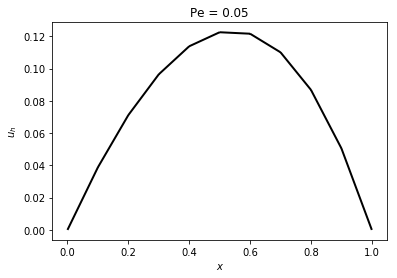

In [132]:
fe.plot(uh)
plt.title('Pe = %.2f'%pe)
plt.xlabel('$x$')
_ = plt.ylabel('$u_h$')

Since we have the exact solution to the problem, we shall look at the error produced.

The exact solution to the above problem is given by
$$ u = \frac{1}{b}\left(x - \frac{1-e^{\frac{bx}{\epsilon}}}{1-e^{\frac{b}{\epsilon}}}\right) $$

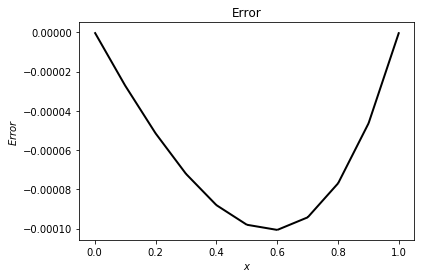

In [133]:
u_exact = (x - (1-fe.exp(b*x/epsilon))/(1-fe.exp(b/epsilon)))/b
difference = fe.assemble(fe.interpolate(u_exact, V) - uh)
fe.plot(difference)
plt.xlabel('$x$')
plt.ylabel('$Error$')
_ = plt.title('Error')


Since the 1d plotting interface of `firedrake` is a bit difficult to visualize the numerical solution and the exact solution, we shall use the `matplotlib.pyplot` to plot. We define a function `myplot` which takes numerical solution $u_h$, diffusion coefficient $b$, convection coefficient $\epsilon$ and Peclet number $Pe$ as arguments and plots the exact and numerical solution. 

In [134]:
def myplot(uh, b, epsilon, pe):
    """Plots 1d solution and exact solution
    
    Key arguments:
    
    uh - Numerical solution to the 1-d problem
    
    b - convection coefficient
    
    epsilon - diffusion coefficient
    
    pe - Peclet number
    
    """
    x = np.arange(0,1.0001,0.1)


    plt.plot(x,uh(x),'--ob', label = '$u_h$')

    x = np.arange(0,1.0001,0.0001)
    u_exact = (x - (1-np.exp(b*x/epsilon))/(1-np.exp(b/epsilon)))/b

    plt.plot(x,u_exact,'-g', label = '$u_{exact}$')
    plt.xlabel('$x$')
    plt.ylabel('$u_h$')
    plt.title('Pe = %.2f '%pe)
    plt.legend(loc = 'upper left')
    plt.grid(True)
    
    return

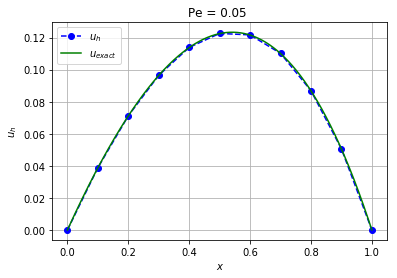

In [135]:
myplot(uh,b,epsilon,pe)

Now, let us write the code as a function which solves the above problem by Galerkin by taking convection coefficient $\epsilon$, diffusion coefficient $b$ and mesh size $N$ as arguments.

In [138]:
def galerkin(epsilon, b, N):
    """Solves the 1-d problem by Galerin
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    b -  convection coefficient
    
    N - mesh size 
    
    """
    e = epsilon

    h = 1/N
    
    pe = peclet_number(b,N,e)
    print('Pe =',pe)

    L = f*v*dx
    a =  ( e* dot(grad(v),grad(u)) ) * dx + b * u.dx(0) * v * dx 
    
    fe.solve(a == L, uh, bcs=bc)
    
    myplot(uh, b, e, pe)
    
    return  
    

Now we shall solve the problem for different values of diffusion coefficient $\epsilon$ and convection coeffient $b$ and compare the analytical and exact solution for the different values of Peclet number $Pe$.

Pe = 0.05


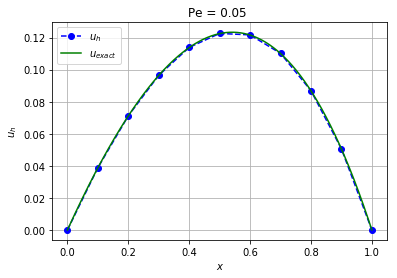

In [139]:
galerkin(1,1,10)

Pe = 0.5


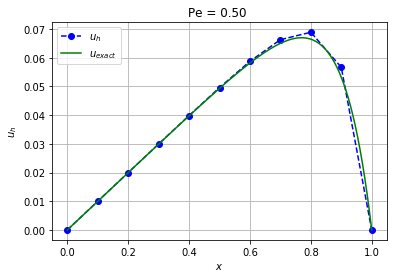

In [140]:
galerkin(1,10,10)

Pe = 1.0


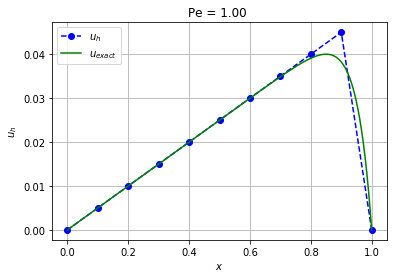

In [141]:
galerkin(1,20,10)

Pe = 2.5


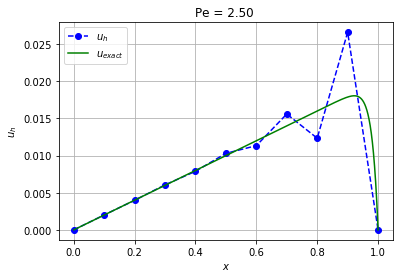

In [142]:
 galerkin(1,50,10)

Pe = 5.0


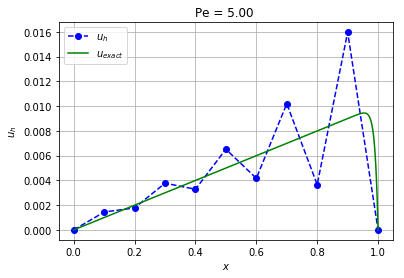

In [143]:
galerkin(1,100,10)

Pe = 25.0


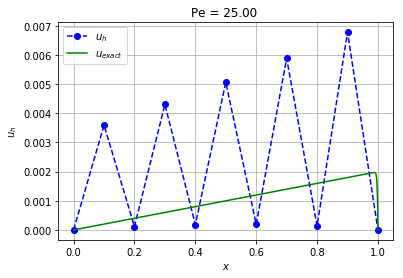

In [144]:
galerkin(1,500,10)

It can be seen that the Galerkin method has problems in the convection dominated case $Pe>1$ where the solution is oscillatory. A way of overcoming this is by increasing the number of points in the grid to force $Pe \approx 1$. However, this is not always possible as it increases computatonal cost significantly. 

Following are some ways to stabilize the convection-diffusion equation.

### 2. Artificial Diffusion

In this method, an artificial diffusion is added such that it reduces the mesh Peclet number to an effective Peclet number of almost unity.

Now, the variational form becomes
$$ (\epsilon + \epsilon_h) \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx = \int_\Omega v\,dx $$
where, $\epsilon_h$ is the artificial diffusion coefficient.

Now let us write the problem in bilinear form as follows

$$ u \in V: \;\;\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := (\epsilon + \epsilon_h) \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx$$

$$ l(v) := \int_\Omega v\,dx $$

The value of $\epsilon_h$ is chosen such that it reduces the Peclet number. Choose $ \epsilon_h = \frac{\gamma}{2} hb$ 

If $\gamma \geq 1$, the effective Peclet number is sufficiently small and hence diffusion is minimized.

For perfect stabilization we can use $\gamma = \textrm{coth}(Pe)-1/Pe$

Let us write a function `artificial_diffusion` to solve the problem by adding artficial diffusion $\epsilon_h$.  

In [145]:
def artificial_diffusion(epsilon, b, N):
    """Solves the 1-d problem by Artfificial diffusion
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    b - convection coefficient
    
    N - mesh size 
    
    """
    e = epsilon

    h = 1/N
    
    pe = peclet_number(b,N,e)
    print('Pe =',pe)
    
    gamma = ( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)  # For perfect stabilization
    eh = gamma/2*h*b # artificial diffusion coefficient
    pe_eff = b*h/(2*(e+eh)) # Effective Peclet number
    print('Effective Pe = ',pe_eff)

    dx, dot, grad = fe.dx, fe.dot, fe.grad
    L = f*v*dx
    a =  ( (e+eh)* dot(grad(v),grad(u)) ) * dx + b * u.dx(0) * v * dx 
    
    fe.solve(a == L, uh, bcs=bc)
    
    myplot(uh, b, e, pe)
    
    return 
    

Now we shall solve the problem by artificial diffusion method for different values of diffusion coefficient $\epsilon$ and convection coeffient $b$ and compare the analytical and exact solution for the different values of Peclet number $Pe$.

Pe = 0.05
Effective Pe =  0.04995837495788001


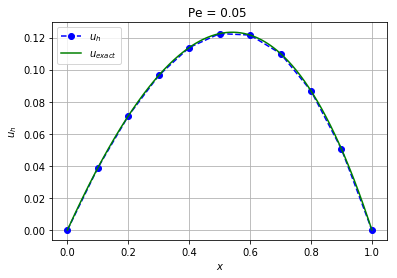

In [146]:
artificial_diffusion(1,1,10)

Pe = 0.5
Effective Pe =  0.46211715726000974


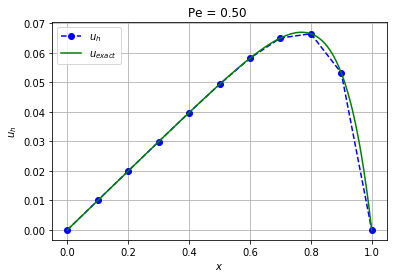

In [147]:
artificial_diffusion(1,10,10)

Pe = 1.0
Effective Pe =  0.761594155955765


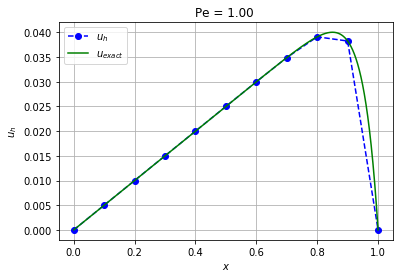

In [148]:
artificial_diffusion(1,20,10)

Pe = 2.5
Effective Pe =  0.9866142981514302


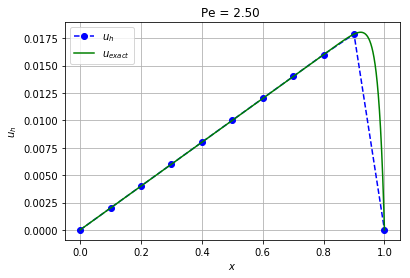

In [149]:
artificial_diffusion(1,50,10)

Pe = 5.0
Effective Pe =  0.9999092042625951


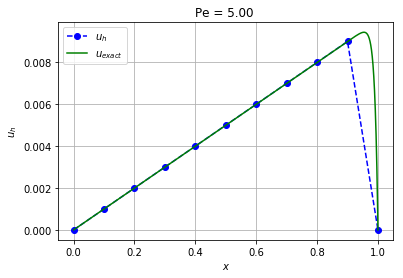

In [150]:
artificial_diffusion(1,100,10)

Pe = 25.0
Effective Pe =  1.0


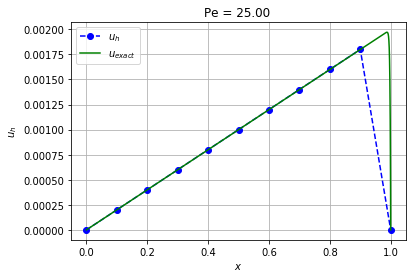

In [151]:
artificial_diffusion(1,500,10)

It can be observed that the problems in Galerkin method have been clearly overcome by the artficial diffusion method. We do not see any oscillations in the solution at higher Peclet number $Pe$ and can see that the solution is stable.
However, we will later see that this method does pose problems when it comes to consistency. This will be demonstrated later in Problem 2.

For now, we shall discuss another method of stabilizing the numerical solution.

### 3. SUPG

In this method, the modified test function $ v + \delta b v' $ is used. Where $\delta$ is a mesh dependent stabilization parameter.

Multiplying by test function $ v+\delta b v' $ on both sides of the convection-diffusion equation and integrating by parts over the domain $\Omega$

$$ \int_\Omega (-\epsilon u''+bu')(v + \delta b v') dx = \int_\Omega (v + \delta b v') dx $$

$$ \epsilon \int_\Omega u'v'dx + b\int_\Omega u'vdx + \delta b^2 \int_\Omega u'v'dx = \int_\Omega (v + \delta b v') dx $$  

Writing the problem in compact form:

$$ u \in V: \;\;\;\;\;a(u,v) = l(v) \;\;\;\;\forall v \in V$$

$$ a(u,v) := \epsilon \int_\Omega u'v'dx + b\int_\Omega u'vdx + \delta b^2 \int_\Omega u'v'dx $$

$$ l(v) := \int_\Omega (v + \delta b v') dx $$

$\delta$ is a mesh dependent stabilization parameter. Choose $\delta = \frac{h}{2b}\left(\textrm{coth}Pe - \frac{1}{Pe}\right)$

Let us write a function `supg` to solve the problem.

In [152]:
def supg(epsilon, b, N):
    """Solves the 1-d problem by SUPG
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    b - convection coefficient
    
    N - mesh size 
    
    """
    e = epsilon

    h = 1/N
    
    pe = peclet_number(b,N,e)
    print('Pe =',pe)
    
    delta = (h/(2*b))*( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)  # For perfect stabilization

    L = f*v*dx + delta*b*v.dx(0)*dx
    a = ( e * dot(grad(v),grad(u)) ) * dx + ( b * u.dx(0) * v * dx) + delta * b * b * dot(grad(v),grad(u)) * dx
    
    fe.solve(a == L, uh, bcs=bc)
    
    myplot(uh, b, e, pe)
    
    return 

Now we shall solve the problem by SUPG method for different values of diffusion coefficient $\epsilon$ and convection coeffient $b$ and compare the analytical and exact solution for the different values of Peclet number $Pe$.

Pe = 0.05


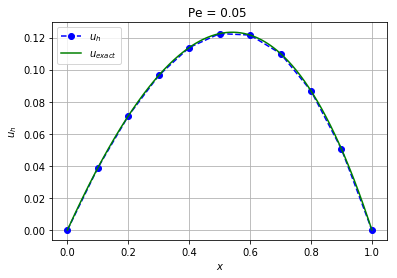

In [153]:
supg(1,1,10)

Pe = 0.5


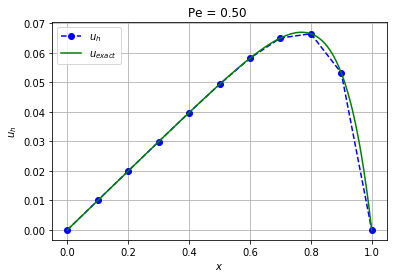

In [154]:
supg(1,10,10)

Pe = 1.0


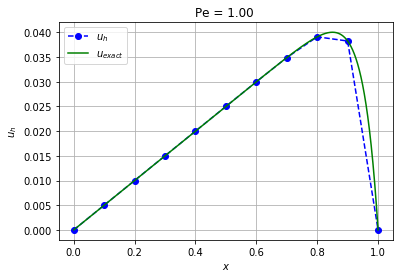

In [155]:
supg(1,20,10)

Pe = 2.5


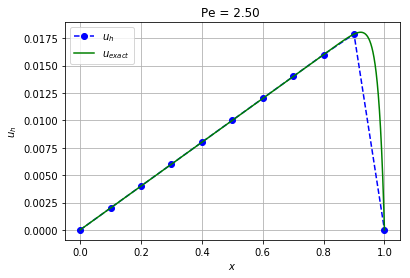

In [156]:
supg(1,50,10)

Pe = 10.0


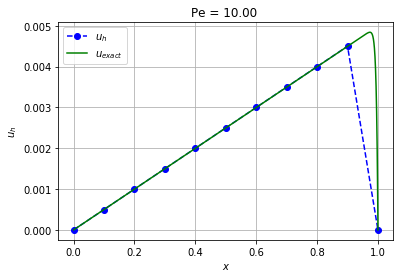

In [157]:
supg(1,200,10)

Pe = 25.0


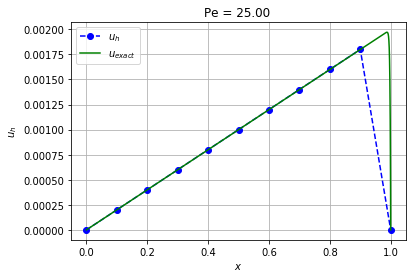

In [158]:
supg(1,500,10)

It can be seen that SUPG method produces stable solutions even at higher Peclet numbers $Pe$. SUPG method is better than artificial diffusion method as SUPG is a strongly consistent method while artificial diffusion method is inconsistent. This is demonstrated in Problem 2 below.

## Problem 2:

Consider the convection-diffusion equation : 

$$ -\epsilon u'' + bu' = \textrm{sin}(\pi x),\;\;\textrm{for} \;x \in [0,1]$$

$$ u(0) = 0,\,\,u(1) = 1 $$

where, $\epsilon$ and $b$ are diffusion and convection coefficients respectively.

Note that the problem 2 is very similar to problem 1 with the source term being function of $x$ (sin $\pi x$) in problem 2 while the source term was a constant in Problem 1. The boundary conditions are similar in both problems i.e Dirichlet boundary conditions in both problems. However, note that the values at the boundary are different for the problems.

### 1. Artificial Diffusion

Now, the variational form becomes
$$ (\epsilon + \epsilon_h) \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx = \int_\Omega \textrm{sin}(\pi x)\,v\,dx $$
where, $\epsilon_h$ is the artificial diffusion coefficient.

Now let us write the problem in bilinear form as follows

$$ u \in V: \;\;\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := (\epsilon + \epsilon_h) \int_\Omega u'v' dx\, +b \int_\Omega u'v\,dx$$

$$ l(v) := \int_\Omega \textrm{sin}(\pi x)\,v\,dx $$

Let us write a function `artificial_siffusion_sin` which solves the above problem by artfificial diffuson taking diffusion coefficient $\epsilon$, conection coefficient $b$ and grid size $N$ as arguments.

In [193]:
def artificial_diffusion_sin(epsilon, b , N):
    """Solves the 1-d problem by Artficial Diffusion
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    b - convection coefficient
    
    N - mesh size 
    
    """
    e= epsilon
    
    mesh = UnitIntervalMesh(N)
    h = 1/N
    pe = b*h/(2*e) # Peclet Number

    gamma = ( ((exp(2*pe)+1)/(exp(2*pe)-1)) - 1/pe)  # For perfect stabilization
    eh = gamma/2*h*b # artificial diffusion coefficient
    pe_eff = b*h/(2*(e+eh)) # Effective Peclet number

    V = FunctionSpace(mesh, 'CG', 1)
    u = TrialFunction(V)
    v = TestFunction(V)

    x = SpatialCoordinate(mesh)[0]
    pi = 3.14159
    f = Function(V)
    f = sin(pi*x)


    boundary_ids1 = {1} # boundaries x=0 
    boundary_ids2 = {2} # boundaries x=1 

    bc1 = DirichletBC(V,0,boundary_ids1) # Boundary conditions for x=0, u=0
    bc2 = DirichletBC(V,1,boundary_ids2) # Boundary conditions for x=1, u=1

    uh = Function(V)
    L = f*v*dx
    a = ( (e+eh) * dot(grad(v),grad(u)) ) * dx + b *u.dx(0)* v * dx 

    solve(a == L, uh, bcs=[bc1,bc2])

    print('Pe =',pe)
    print('Effective Pe = ',pe_eff)
    print('Artficial Diffusion =',eh)

    x = np.arange(0,1.0001,0.1)

    plt.plot(x,uh(x),'--ob', label = '$u_h$')
    x = np.arange(0,1.0001,0.0001)
    aux = pi*(b**2+e**2*pi**2);
    d = np.exp(b/e);
    c1 = (-aux+b*(d+1))/(aux*(d-1));
    c2 = (aux-2*b)/(aux*(d-1));
    u_exact = c1 + c2*np.exp(b*x/e) + e*pi*(np.sin(pi*x)-b*np.cos(pi*x)/(e*pi))/aux;


    plt.plot(x,u_exact,'-g', label = '$u_{exact}$')
    plt.title('Pe = %.2f '%pe)
    plt.xlabel('$x$')
    plt.ylabel('$u_h$')
    plt.legend(loc = 'upper left')
    plt.grid(True)

    return


Now we shall solve the above problem by artificial diffusion method for different values of diffusion coefficient $\epsilon$ and convection coeffient $b$ and compare the analytical and exact solution for the different values of Peclet number $Pe$.

Pe = 0.1
Effective Pe =  0.09966799462495583
Artficial Diffusion = 0.001665556612699426


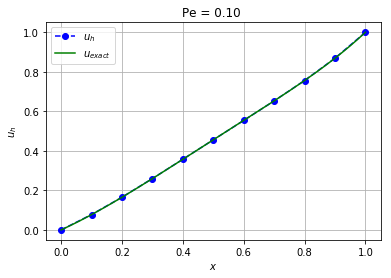

In [194]:
artificial_diffusion_sin(0.5,1,10)

Pe = 1.0
Effective Pe =  0.761594155955765
Artficial Diffusion = 0.015651764274966562


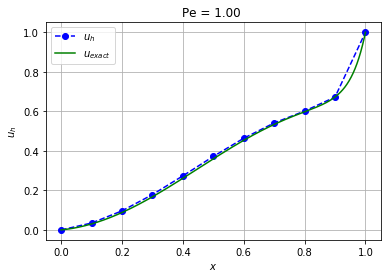

In [195]:
artificial_diffusion_sin(0.05,1,10)

Pe = 10.0
Effective Pe =  0.999999995877693
Artficial Diffusion = 0.04500000020611536


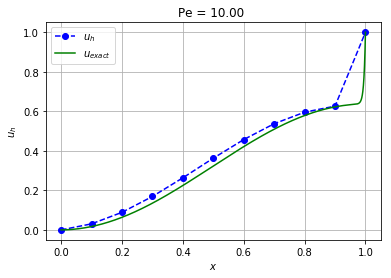

In [196]:
artificial_diffusion_sin(0.005,1,10)

It can be seen that artificial diffusion method does not give accurate results for higher Peclet numbers. This is mainly because we are not solving the strong form exactly. In other words, the variational form is not consistent with the strong form. We shall see that SUPG is a strongly consistent method.

### 2. SUPG

Multiplying by test function $ v+\delta \,b\, v' $ on both sides of the convection-diffusion equation and integrating over domain $\Omega$

$$ \int_\Omega (-\epsilon u''+bu')(v + \delta b v') dx = \int_\Omega \textrm{sin}(\pi x)\,(v + \delta b v') dx $$

$$ \epsilon \int_\Omega u'v'dx + b\int_\Omega u'vdx + \delta b^2 \int_\Omega u'v'dx = \int_\Omega \textrm{sin}(\pi x)\, v\,dx + \delta b \int_\Omega  \textrm{sin}(\pi x) \, v' dx $$ 

Variational formulation:

$$ u \in V: \;\;\;\;\;a(u,v) = l(v) \;\;\;\;\forall v \in V$$

$$ a(u,v) := \epsilon \int_\Omega u'v'dx + b\int_\Omega u'vdx + \delta b^2 \int_\Omega u'v'dx $$

$$ l(v) := \int_\Omega \textrm{sin}(\pi x)\, v\,dx + \delta b \int_\Omega  \textrm{sin}(\pi x) \, v' dx$$

In [233]:
def supg_sin(epsilon, b, N):
    """"Solves the 1-d problem by SUPG
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    b - convection coefficient
    
    N - mesh size 
    
    """   
    e = epsilon
    
    mesh = UnitIntervalMesh(N)
    
    V = FunctionSpace(mesh, 'CG', 1)
    u = TrialFunction(V)
    v = TestFunction(V)
    
    x = SpatialCoordinate(mesh)[0]

    pi = 3.14159
    f = Function(V)
    f = sin(pi*x)

    boundary_ids1 = {1} # boundaries x=0 
    boundary_ids2 = {2} # boundaries x=1 

    bc1 = DirichletBC(V,0,boundary_ids1) # Boundary conditions for x=0, u=0
    bc2 = DirichletBC(V,1,boundary_ids2) # Boundary conditions for x=1, u=1

    h = 1/N
    pe = b/(2*e*N)
    dell = (h/(2*b))*( ((exp(2*pe)+1)/(exp(2*pe)-1)) - 1/pe)

    uh = Function(V)
    L = f*v*dx + dell*b*f*v.dx(0)*dx
    a = ( e * dot(grad(v),grad(u)) ) * dx + ( b * u.dx(0) * v * dx) + dell * b * b * dot(grad(v),grad(u)) * dx

    solve(a == L, uh, bcs=[bc1,bc2])
    
    print('Pe =',pe)

    x = np.arange(0,1.0001,0.1)
    plt.plot(x,uh(x),'--ob', label = '$u_h$')
    x = np.arange(0,1.0001,0.0001)
    aux = pi*(b**2+e**2*pi**2);
    d = np.exp(b/e);
    c1 = (-aux+b*(d+1))/(aux*(d-1));
    c2 = (aux-2*b)/(aux*(d-1));
    u_exact = c1 + c2*np.exp(b*x/e) + e*pi*(np.sin(pi*x)-b*np.cos(pi*x)/(e*pi))/aux;

    plt.plot(x,u_exact,'-g', label = '$u_{exact}$')
    plt.title('Pe = %.2f '%pe)
    plt.xlabel('$x$')
    plt.ylabel('$u_h$')
    plt.legend(loc = 'upper left')
    plt.grid(True)
    
    return


Now we shall solve the above problem by SUPG method for different values of diffusion coefficient $\epsilon$ and convection coeffient $b$ and compare the analytical and exact solution for the different values of Peclet number $Pe$.

Pe = 0.1


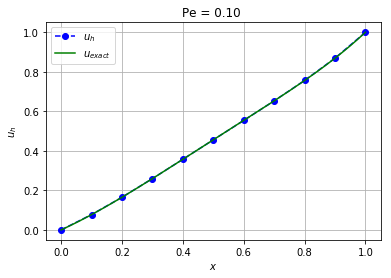

In [234]:
supg_sin(0.5,1,10)

Pe = 1.0


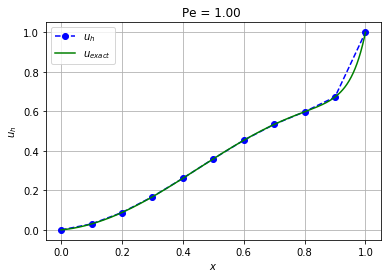

In [199]:
supg_sin(0.05,1,10)

Pe = 10.0


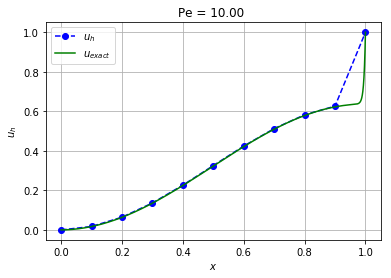

In [200]:
supg_sin(0.005,1,10)

It can be seen the SUPG produces consistent solution even for higher Peclet numbers $Pe$.

### Conclusion

-> It can be seen that Galerkin method is not suited for convection dominated problems i.e $Pe >1$. 

-> Artificial diffusion method produces stable solution but lacks consistency. 

-> SUPG is a strongly consistent method.

Let us now consider a 2d problem to see how the three methods discussed above produces solutions in 2d.

## Problem 3: 2d Problem

Consider the 2d convection-diffusion equation with dirichlet boundary condition :

$$ -\epsilon \nabla^2u + b.\nabla u = 0,\;\;\textrm{in} \;\;\Omega = [0,1]\times[0,1]$$

$$ u = 1\;\;\;\forall x=0$$

$$ u = 0\;\;\;\forall y=0 $$



where, $\epsilon$ and $b$ are diffusion and convection coefficients respectively.
We seek to find the solution $u \in V$, where $V$ is some finite element space satisfying the boundary condition.

### 1. Galerkin

We write the above problem in variational form by multiplying by test function $v \in V$ and integrating by parts over domain $\Omega$ 

$$ \epsilon \iint_\Omega (\nabla u. \nabla v) \,dx\,dy + \iint_\Omega (b. \nabla u) \;v\,dx\,dy = 0$$

Now let us write the problem in compact form as follows

$$ u \in V:\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := \epsilon \iint_\Omega (\nabla u. \nabla v) \,dx\,dy + \iint_\Omega (b. \nabla u) \;v\,dx\,dy$$

$$ l(v) := 0 $$

Let us write a function `galerkin2d` to solve the above problem by galerkin. Let the convection coeffient $b$ be $(0.866,0.5)$ i.e $0.866$ in $x$-direction and $0.5$ in in $y$-direction respectively. The diffusion coefficient $\epsilon$ and grid size $N$ will be passed as arguments to the function.

In [205]:
def galerkin2d(epsilon,N):
    """Solves the 2-d problem by Galerin
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    N - mesh size 
    
    """
    
    e = epsilon

    mesh = fe.UnitSquareMesh(N,N)

    V = fe.FunctionSpace(mesh, 'CG', 1)
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    x,y = fe.SpatialCoordinate(mesh)
    
    f = fe.Constant(0)
    
    b = 0.86*fe.unit_vectors(2)[0] + 0.5*fe.unit_vectors(2)[1] #convection constant

    boundary_ids1 = {1} # boundaries x=0 and x=1
    boundary_ids2 = {3} # boundaries y=0 and y=1

    bc1 = fe.DirichletBC(V,1,boundary_ids1) # Boundary conditions for x=0 
    bc2 = fe.DirichletBC(V,0,boundary_ids2) # Boundary conditions for y=0 

    uh = fe.Function(V)
    L = f* v *dx
    a =  e * dot( grad(v), grad(u))  * dx + dot(b, grad(u)) * v * dx

    fe.solve(a == L, uh, bcs=[bc1,bc2])
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    fe.plot(uh, plot3d = 'TRUE')
    
    
    return
    


Now we shall solve the problem for different values of diffusion coefficient $\epsilon$ and convection coeffient $b$ and compare the analytical and exact solution for the different values of Peclet number $Pe$.

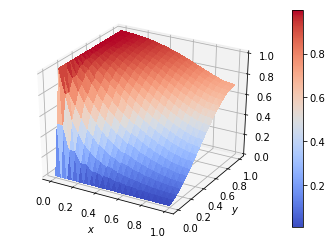

In [207]:
galerkin2d(0.1,10)

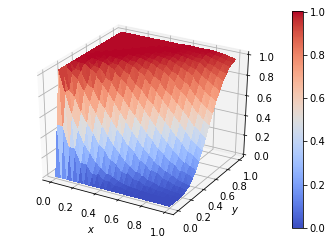

In [208]:
galerkin2d(0.01,10)

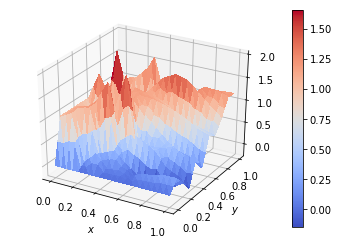

In [209]:
galerkin2d(0.001,10)

As expected, the galerkin method produces oscillations for higher Peclet numbers $Pe$.

### 2. Artficial diffusion

In this method, an artificial diffusion is added such that it reduces the mesh Peclet number to an effective Peclet number of almost unity.

Now, the variational form becomes
$$ (\epsilon+\epsilon_h) \iint_\Omega (\nabla u. \nabla v) dx\,dy + \iint_\Omega (b.\nabla u) \;v\,dx\,dy =  0 $$
where, $\epsilon_h$ is the artificial diffusion coefficient.

Now let us write the problem in bilinear form as follows

$$ u \in V:\;\;\;\;a(u,v) = l(v)\;\;\;\;\;\;\forall v\in V$$

$$ a(u,v) := (\epsilon+\epsilon_h) \iint_\Omega (\nabla u. \nabla v) dx\,dy + \iint_\Omega (b.\nabla u) \;v\,dx\,dy$$

$$ l(v) :=  0 $$

The value of $\epsilon_h$ is chosen such that it reduces the Peclet number. Choose $ \epsilon_h = \frac{\gamma}{2} hb$. 

If $\gamma \geq 1$, the effective Peclet number is sufficiently small and hence diffusion is minimized.

For perfect stabilization use $\gamma = \textrm{coth}(Pe)-1/Pe$

Let us write a function `artificial_diffusion2d` to solve the above 2d problem by artificial diffusion. Let the convection coeffient $b$ be $(0.866,0.5)$ i.e $0.866$ in $x$-direction and $0.5$ in in $y$-direction respectively. The diffusion coefficient $\epsilon$ and grid size $N$ will be passed as arguments to the function.

In [211]:
def artificial_diffusion2d(epsilon,N):
    """Solves the 2-d problem by Artificial diffusion
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    N - mesh size 
    
    """
    
    e = epsilon
    h = 1/N
    
    mesh = fe.UnitSquareMesh(N,N)

    V = fe.FunctionSpace(mesh, 'CG', 1)
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    x,y = fe.SpatialCoordinate(mesh)
    
    f = fe.Constant(0)
    
    b = 0.86*fe.unit_vectors(2)[0] + 0.5*fe.unit_vectors(2)[1] #convection constant

    boundary_ids1 = {1} # boundaries x=0 and x=1
    boundary_ids2 = {3} # boundaries y=0 and y=1

    bc1 = fe.DirichletBC(V,1,boundary_ids1) # Boundary conditions for x=0 
    bc2 = fe.DirichletBC(V,0,boundary_ids2) # Boundary conditions for y=0 

    pe = fe.sqrt(fe.dot(b,b))*h/(2*fe.sqrt(fe.dot(e,e))) # Peclet Number
    gamma = ( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)  # For perfect stabilization
    eh = gamma/2*h*fe.sqrt(fe.dot(b,b)) # artificial diffusion coefficient

    uh = fe.Function(V)
    L = f * v * dx
    a =   (e+eh) * dot( grad(u), grad(v))  * dx  + dot(b, grad(u)) * v * dx 

    fe.solve(a == L, uh, bcs=[bc1,bc2])
    
    fe.plot(uh, plot3d = 'TRUE')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
    return

Now we shall solve the above problem by artificial diffusion method for different values of diffusion coefficient $\epsilon$ and convection coeffient $b$ and compare the analytical and exact solution for the different values of Peclet number $Pe$.

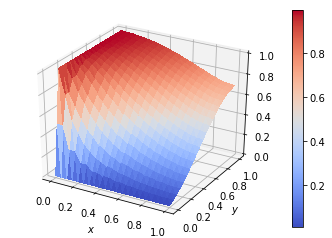

In [212]:
artificial_diffusion2d(0.1,10)

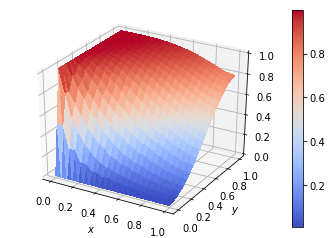

In [213]:
artificial_diffusion2d(0.01,10)

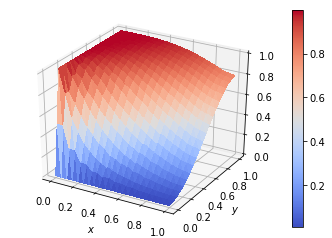

In [214]:
artificial_diffusion2d(0.001,10)

We see that artificial diffusion method produces stable solution. However we do notice higher diffusion in this method due to the additional artificial diffusion added to the variational form.

### 3. SUPG

In this method, the modified test function $ v + \delta b \nabla v $ is used. Where $\delta$ is a mesh dependent stabilization parameter.

Multiplying by test function $ v+\delta b \nabla v $ on both sides of the convection-diffusion equation and integrating by parts over domain $\Omega$

$$ \iint_\Omega (-\epsilon \nabla^2u + b.\nabla u)(v+\delta\, b. \nabla v) dx\,dy = 0 $$

$$ \epsilon \iint_\Omega (\nabla u.\nabla v)\, dx\,dy + \iint_\Omega (b.\nabla u) \,v\,dx\,dy + \delta \iint_\Omega (b.\nabla u) (b.\nabla v)\, dx\,dy = 0 $$  

Variational formulation:

$$ u \in V: \;\;\;\;\;a(u,v) = l(v) \;\;\;\;\forall v \in V$$

$$ a(u,v) := \epsilon \iint_\Omega (\nabla u.\nabla v)\, dx\,dy + \iint_\Omega (b.\nabla u) \,v\,dx\,dy + \delta \iint_\Omega (b.\nabla u) (b.\nabla v)\, dx\,dy $$

$$ l(v) := 0 $$

$\delta$ is a mesh dependent stabilization parameter. Choose $\delta = \frac{h}{2b}\left(\textrm{coth}Pe - \frac{1}{Pe}\right)$

Let us write a function `supg2d` to solve the above 2d problem by SUPG. Let the convection coefficient $b$ be $(0.866,0.5)$ i.e $0.866$ in $x$-direction and $0.5$ in in $y$-direction respectively. The diffusion coefficient $\epsilon$ and grid size $N$ will be passed as arguments to the function.

In [215]:
def supg2d(epsilon,N):
    """Solves the 2-d problem by SUPG
    
    Key Arguments:
    
    epsilon - diffusion coefficient
    
    N - mesh size 
    
    """
    
    e = epsilon
    h = 1/N
    
    mesh = fe.UnitSquareMesh(N,N)

    V = fe.FunctionSpace(mesh, 'CG', 1)
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    x,y = fe.SpatialCoordinate(mesh)
    
    f = fe.Constant(0)
    
    b = 0.86*fe.unit_vectors(2)[0] + 0.5*fe.unit_vectors(2)[1] #convection constant

    boundary_ids1 = {1} # boundaries x=0 and x=1
    boundary_ids2 = {3} # boundaries y=0 and y=1

    bc1 = fe.DirichletBC(V,1,boundary_ids1) # Boundary conditions for x=0 
    bc2 = fe.DirichletBC(V,0,boundary_ids2) # Boundary conditions for y=0 
    
    pe = fe.sqrt(fe.dot(b,b))*h/2/e # Peclet Number
    gamma = ( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)  # For perfect stabilization
    delta = h/(2*fe.sqrt(fe.dot(b,b)))*( ((fe.exp(2*pe)+1)/(fe.exp(2*pe)-1)) - 1/pe)

    uh = fe.Function(V)
    L = f*v*dx + delta*dot(b,grad(v))*f*dx
    a =  e * dot( grad(v), grad(u)) * dx + dot(b,grad(u)) * v * dx + delta * dot(b,grad(u))*dot(b,grad(v)) * dx

    fe.solve(a == L, uh, bcs=[bc1,bc2])
    
    fe.plot(uh, plot3d = 'TRUE')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
    return

Now we shall solve the above problem by SUPG method for different values of diffusion coefficient $\epsilon$ and convection coeffient $b$ and compare the analytical and exact solution for the different values of Peclet number $Pe$.

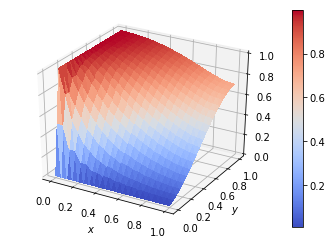

In [216]:
supg2d(0.1,10)

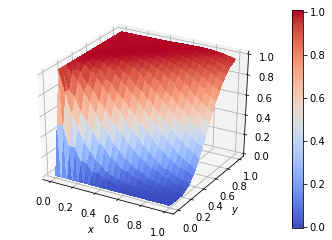

In [217]:
supg2d(0.01,10)

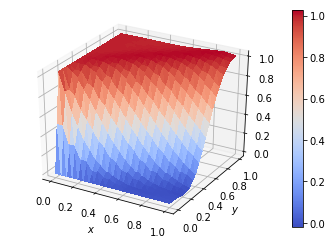

In [218]:
supg2d(0.001,10)

We see that SUPG method produces stable solutions. We can also observe that SUPG method produces solution with lesser diffusion when compared to artificial difusion method.

### Conclusion

It is seen that the galerkin method is unstable and produces oscillatory results for convection dominated problems. Artificial diffusion method is more stable but produces excessive diffusion in the results. SUPG method produces stable results.

## References

1. Finite Element Methods fo Fluif flow Problems - Jean Donea and Antonio Huerta
2. http://ww2.lacan.upc.edu/huerta/exercises/SteadyTransport/SteadyTransport.htm